加工後のデータフレーム:
   index dirname                                               path  width  \
0      0      61  ../mydata/00_working/2022-05-02/61/59-62-65-IM...   3000   
1      1      61  ../mydata/00_working/2022-05-02/61/24-30-36-IM...   3000   
2      2      61  ../mydata/00_working/2022-05-02/61/29-35-40-IM...   3000   
3      3      61  ../mydata/00_working/2022-05-02/61/23-3-11-DSC...   3000   
4      4      61  ../mydata/00_working/2022-05-02/61/40-45-5-DSC...   3000   

   height               created_time              modified_time color_mode  \
0    2000 2024-11-22 20:05:13.475698 2024-11-22 20:05:13.475698        RGB   
1    2000 2024-11-22 20:05:13.295251 2024-11-22 20:05:13.295251        RGB   
2    2000 2024-11-22 20:05:13.871609 2024-11-22 20:05:13.871609        RGB   
3    2000 2024-11-22 20:05:13.666497 2024-11-22 20:05:13.666497        RGB   
4    2000 2024-11-22 20:05:14.076683 2024-11-22 20:05:14.076683        RGB   

     file_size  
0  5194.587891  
1  8368.643555 

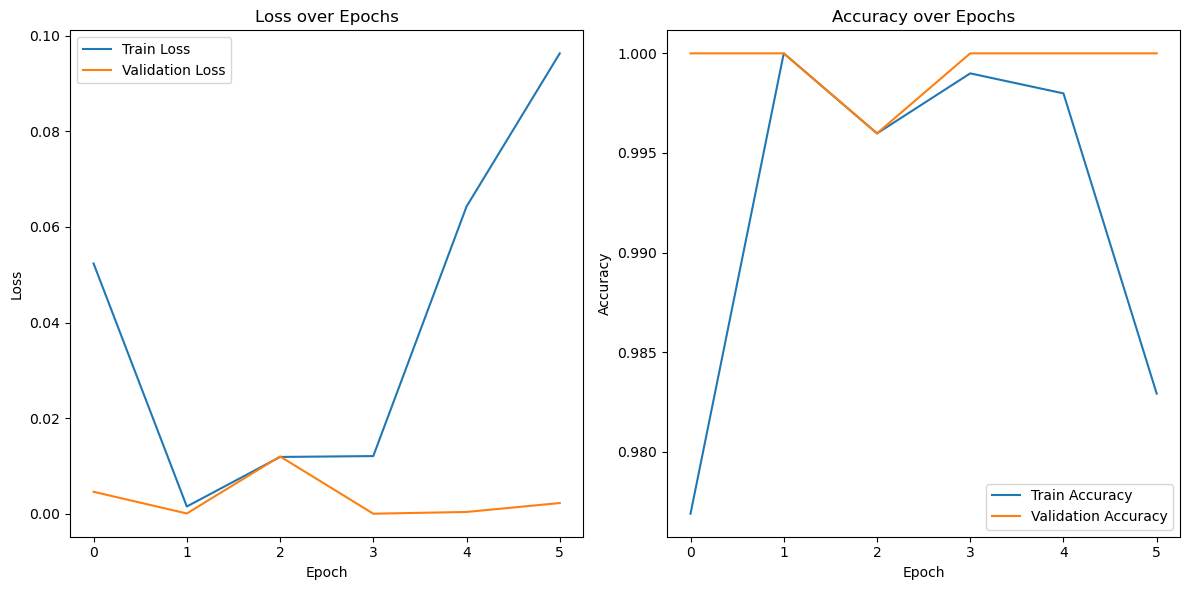

In [1]:
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import models, transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt

# データセットのパス
parquet_file_path = "../03_Collect_Images/images.parquet"

# Parquetファイルの読み込み
df = pd.read_parquet(parquet_file_path)

# 指定された条件で抽出
df = df[
    (df['readable'] == True) &
    (df['width'] >= 256) &
    (df['height'] >= 256) &
    (df['color_mode'].isin(['RGB', 'RGBA'])) &
    (df['exclude_same_folder'] == False) &
    (df['exclude_cross_folder'] == 'include') &
    (df['too_small'] == False) &
    (~df['path'].str.contains('chart'))  # 'chart'を含む行を除外
]

# 不要な列の削除
df = df.drop(columns=['readable', 'exclude_same_folder', 'exclude_cross_folder', 'too_small', 'hash'])

# index列を0列目に移動
columns = ['index'] + [col for col in df.columns if col != 'index']
df = df[columns]

# 結果の確認
print("加工後のデータフレーム:")
print(df.head())


# 口腔内写真の抽出
oral_images = df[df['path'].str.contains('ForensicMedicine')]

# 口腔内写真の枚数
num_oral_images = len(oral_images)
print(f"口腔内写真の枚数: {num_oral_images}")

# 一般画像データセットのダウンロード（ImageNetのサブセットとしてCIFAR10を利用）
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CIFAR10データセットのラベルを1に固定
general_dataset = datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform
)
general_dataset = [(img, 1) for img, _ in general_dataset]  # ラベルを1に変換

# 一般画像を口腔内写真と同じ枚数に制限
general_dataset = torch.utils.data.Subset(general_dataset, range(num_oral_images))

# 口腔内写真データセットの定義
class OralDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  # インデックスをリセット
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = 0  # 口腔内写真のラベルを明示的に設定
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


oral_dataset = OralDataset(oral_images, transform=transform)

# データセットの結合
combined_dataset = ConcatDataset([oral_dataset, general_dataset])

# ラベルの確認
labels = [label for _, label in combined_dataset]
print("ユニークなラベル:", set(labels))  # {0, 1} のみであることを確認

# データローダーの作成
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. モデル構築
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)
print(f"Using device: {device}")

# 3. トレーニング
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練エポック数
num_epochs = 50
patience = 5  # Early Stoppingの設定（5エポックで改善がなければ停止）

# Early Stoppingの変数
best_acc = 0.0
best_model_weights = None
no_improve_epochs = 0

# ログ用
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# トレーニングループ
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # 訓練モード
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 検証モード
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # ベストモデルの保存
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_weights = model.state_dict()
        no_improve_epochs = 0  # 改善があったのでリセット
    else:
        no_improve_epochs += 1

    # Early Stopping判定
    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # ログ出力
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# ベストモデルの重みを保存
torch.save(best_model_weights, 'best_model.pth')
print("Best model weights saved to 'best_model.pth'.")

# 折れ線グラフの描画
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 検証データから10枚の画像をランダムに選択して表示
model.eval()
with torch.no_grad():
    val_images, val_labels = next(iter(val_loader))  # 検証データのバッチを取得
    val_images, val_labels = val_images.to(device), val_labels.to(device)
    outputs = model(val_images)
    _, predicted = torch.max(outputs, 1)

# ランダムに10枚の画像を選択
num_samples = min(10, len(val_images))
indices = random.sample(range(len(val_images)), num_samples)
class_names = ['Oral', 'General']

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 5, i + 1)
    img = val_images[idx].cpu().numpy().transpose((1, 2, 0))  # データをnumpy形式に変換
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # 正規化を元に戻す
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.set_title(f"Predicted: {class_names[predicted[idx]]}\nActual: {class_names[val_labels[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import polars as pl


# Parquetファイルの読み込み
parquet_file_path = "../03_Collect_Images/images.parquet"
df = pl.read_parquet(parquet_file_path)

# 指定された条件で抽出
df = df.filter(
    (df['readable'] == True) &
    (df['width'] >= 256) &
    (df['height'] >= 256) &
    (df['color_mode'].is_in(['RGB', 'RGBA'])) &
    (df['exclude_same_folder'] == False) &
    (df['exclude_cross_folder'] == 'include') &
    (df['too_small'] == False) &
    (~df['path'].str.contains('chart'))
)

# 不要な列の削除
df = df.drop(['readable', 'exclude_same_folder', 'exclude_cross_folder', 'too_small', 'hash'])

# index列を0列目に移動
columns = ['index'] + [col for col in df.columns if col != 'index']
df = df.select(columns)

# ファイルの存在確認関数
def check_file_existence(df):
    # ファイルが存在するかを確認
    df = df.with_columns(
        pl.col("path").map_elements(lambda path: os.path.exists(path)).alias("file_exists")
    )
    # 存在する件数と存在しない件数を計算
    total_files = len(df)
    missing_files = len(df.filter(pl.col("file_exists") == False))
    print(f"全ファイル数: {total_files}")
    print(f"存在しないファイル数: {missing_files}")
    return df

# ファイル存在確認の実行
df = check_file_existence(df)

# 存在しないファイルの確認（必要に応じて表示）
print("存在しないファイルの例:")
print(df.filter(pl.col("file_exists") == False).head())


In [ ]:
import polars as pl
import torch
from torchvision import transforms
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import os

# デバイスの設定
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# モデルの復元
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# 推論の前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Parquetファイルの読み込み
parquet_file_path = "../03_Collect_Images/images.parquet"
df = pl.read_parquet(parquet_file_path)

# 条件抽出
df = df.filter(
    (df['readable'] == True) &
    (df['width'] >= 256) &
    (df['height'] >= 256) &
    (df['color_mode'].is_in(['RGB', 'RGBA'])) &
    (df['exclude_same_folder'] == False) &
    (df['exclude_cross_folder'] == 'include') &
    (df['too_small'] == False) &
    (~df['path'].str.contains('chart'))
)

# 不要な列の削除
df = df.drop(['readable', 'exclude_same_folder', 'exclude_cross_folder', 'too_small', 'hash'])

# index列を先頭に移動
columns = ['index'] + [col for col in df.columns if col != 'index']
df = df.select(columns)

# 推論関数
def predict(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        return 'Oral' if predicted.item() == 0 else 'General'
    except Exception as e:
        return f"Error: {e}"

# 推論実行関数
def classify_images(df):
    def process_row(row):
        return predict(row["path"])  # ここでpath列を指定

    # rowsのデバッグ出力
    print("Processing rows:")
    print(df.rows()[0])  # 確認用に最初の行を出力

    # 並列処理を利用した推論
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_row, df.to_dicts()))

    # 結果を追加
    df = df.with_columns(
        pl.Series("EfficientNet", results, dtype=pl.Utf8)  # Warning解消
    )
    return df

# 推論実行
df = classify_images(df)

# データフレームの保存
output_file = "01_General_Oral.parquet"
df.write_parquet(output_file)
print(f"推論結果を保存しました: {output_file}")

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
from PIL import Image

# データフレームの読み込み
df = pl.read_parquet("01_General_Oral.parquet")

# 'path'列のインデックスを取得
path_index = df.columns.index("path")
efficientnet_index = df.columns.index("EfficientNet")

# 'Oral' と 'General' のデータをランダムに50件ずつ抽出
oral_images = df.filter(pl.col("EfficientNet") == "Oral").sample(n=50, seed=42)
general_images = df.filter(pl.col("EfficientNet") == "General").sample(n=50, seed=42)

# 画像の表示関数
def plot_images(df_subset, ax_start, axes, label):
    for idx, row in enumerate(df_subset.rows()):
        image_path = row[path_index]  # path列を取得
        prediction = row[efficientnet_index]  # EfficientNet列を取得
        try:
            # 画像を開き、サムネイル表示用にリサイズ
            img = Image.open(image_path).resize((100, 100))
            ax = axes[ax_start + idx]
            ax.imshow(img)
            ax.set_title(f"{label}\n{prediction}", fontsize=8)  # 推論結果をタイトルに表示
            ax.axis("off")
        except Exception as e:
            # エラー内容と問題の画像パスを表示
            print(f"Error loading image: {image_path}, Error: {e}")

# 描画領域の設定
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

# Oralの画像を表示
plot_images(oral_images, 0, axes, "Oral")

# Generalの画像を表示
plot_images(general_images, 50, axes, "General")

# レイアウト調整と表示
plt.tight_layout()
plt.show()
